# Predictions with the comparison with baseline

Update 10/Nov/2020
add Kernel Ridge Regression as a comparison, parameter setting is the same as GPR.

Upate 05/Nov/2020
Update plots for 7 reps for round 1.

Update 29/Oct/2020  
We now have Round 1's results. We observe that the consensus sequence has very different labels for different plates/rounds. So we decide to normalise to the consensus sequence (before log normalisation and z-normalisation, subtract the mean of each consensus sequence mean in each plate/round). We will call the normalisation methods as **plate normalisation** and **round normalisation** respectively.
Let's see how the predictions look like for different normalisation methods on the following training/testing pairs
- train 80% round 0 and test 20% round 0
- train round 0 and test round 1
- train 80% all data (round 0 + 1) and test the rest

As always, we consider GPR with RBF, one-hot as a baseline model we would like to compare with.
Our model GPR with wd kernel with shift.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Read Data and Set Up

In [2]:
# plate normalisation
# plateRep_Path = '../../data/Results_Microplate_partialTrue_normTrue_plateRep_formatSeq_logTrue.csv'
# round normalisation
roundRep_Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

# plate_df = pd.read_csv(plateRep_Path)
round_df = pd.read_csv(roundRep_Path)

In [3]:
def run_kfold(df,kernel, embedding, train_idx = None, test_idx = None, 
              num_split = 5,num_repeat = 10,s_list = [1],alpha_list= [2],l_list = [6]):
    gpr = GPR_Predictor(df, train_idx = train_idx, test_idx = test_idx, embedding = embedding, kernel_name = kernel)
    result_DataArray_wd = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    # print(result_DataArray_wd[1].mean(axis = -1).mean(axis=-1))
    return result_DataArray_wd

def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
               eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, eva_on='seqs', title = 'Prediction'):
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel, embedding = embedding,     
                                    eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression()
    gpr_train_samples.scatter_plot(title = title)
    
    if predictor == GPR_Predictor and kernel == 'WD_Kernel_Shift':
        # gpr_train_samples.line_plot()
        train_df = gpr_train_samples.train_df.drop_duplicates(subset = ['RBS']).reset_index()
        test_df = gpr_train_samples.test_df.drop_duplicates(subset = ['RBS']).reset_index().drop(columns = ['level_0'])
        train_df['train_test'] = 'train'
        test_df['train_test'] = 'test'
        train_test_df = pd.concat([train_df, test_df])
        train_test_df = train_test_df.reset_index().drop(['level_0'], axis = 1)
        gpr_train_samples.sort_kernel_label_plot(train_test_df, 'Data Similarity and Prediction, sort by label', group_flag = False)
        gpr_train_samples.sort_kernel_label_plot(train_test_df, 'Data Similarity and Prediction, sort by similarity', 'seq_distance', group_flag = False)
    # else:
    #    gpr_train_samples.scatter_plot(title = title) 



## Train and Test on Round 0

X train shape:  (851, 20)
X test shape:  (35, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.1262280625332255
Test:  0.6967545368659718
<function r2_score at 0x7f02711216a8>
Train:  0.8471213269677741
Test:  0.3107835018531081
coverage rate: 
Train:  0.9647473560517039
Test:  0.8571428571428571


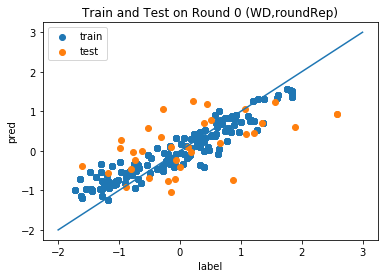

init kernel
groups:  ['all']
Group:  all
Number of sequences:  176
number of clusters:  36


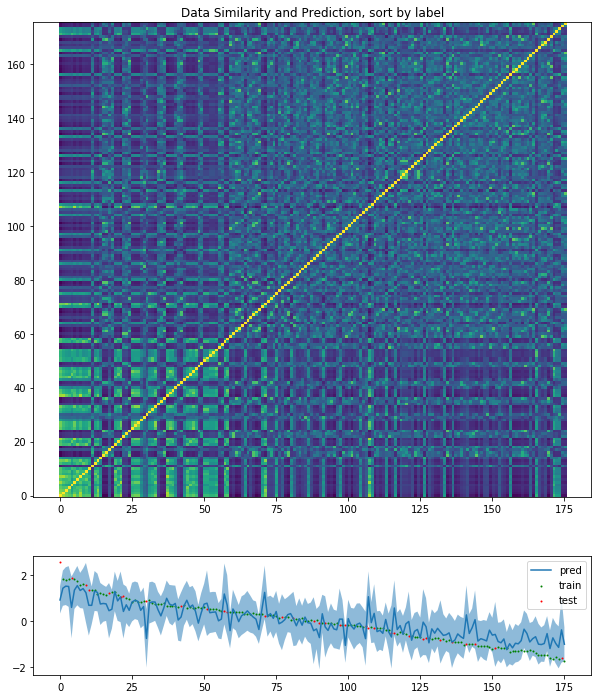

init kernel
groups:  ['all']
Group:  all
Number of sequences:  176
number of clusters:  23


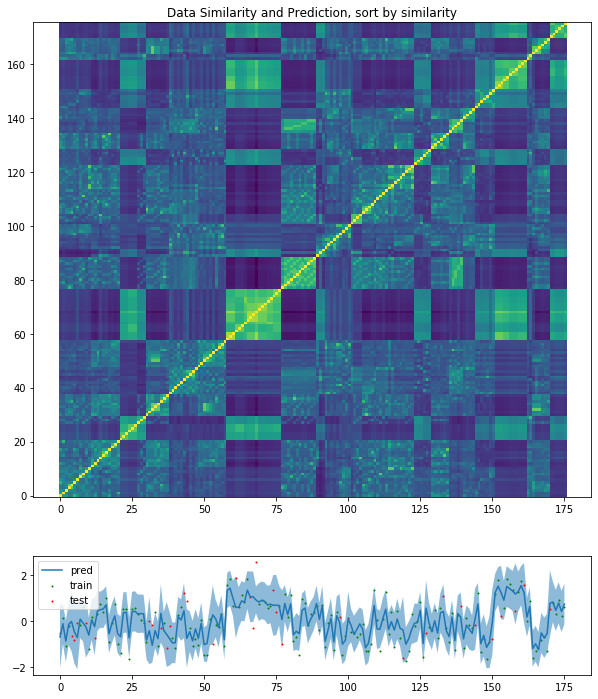

X train shape:  (851, 20)
X test shape:  (35, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.1262275941727204
Test:  0.6967547933541771
<function r2_score at 0x7f02711216a8>
Train:  0.8471218942135281
Test:  0.31078324813979397


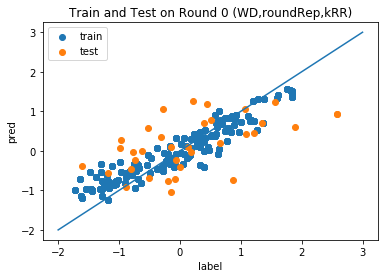

X train shape:  (851, 80)
X test shape:  (35, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.17162572053556135
Test:  0.7303701477703525
<function r2_score at 0x7f02711216a8>
Train:  0.792138832783162
Test:  0.2775315710730113
coverage rate: 
Train:  0.936545240893067
Test:  0.7714285714285715


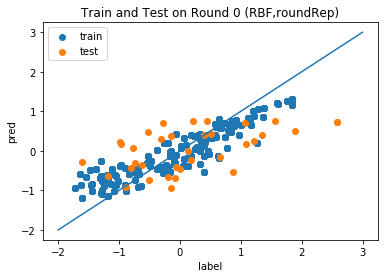

In [4]:
# setting

kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

# run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,plateRep)')
run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (WD,roundRep)')
run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, predictor=KRR_Predictor, title = 'Train and Test on Round 0 (WD,roundRep,kRR)')

kernel = 'RBF'
embedding = 'onehot'

# run_regression(plate_df[plate_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,plateRep)')
run_regression(round_df[round_df['Plate'] != 'Third_Plate'], kernel, embedding, title = 'Train and Test on Round 0 (RBF,roundRep)')

## Train on Round 0 and Test on Round 1

X train shape:  (1061, 20)
X test shape:  (89, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.1557402848223689
Test:  0.9180947033662689
<function r2_score at 0x7f02711216a8>
Train:  0.8208832358674384
Test:  0.01344585732151693
coverage rate: 
Train:  0.9491046182846371
Test:  0.8651685393258427


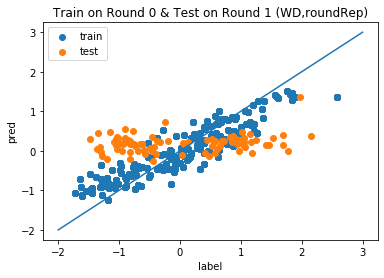

init kernel
groups:  ['all']
Group:  all
Number of sequences:  265
number of clusters:  54


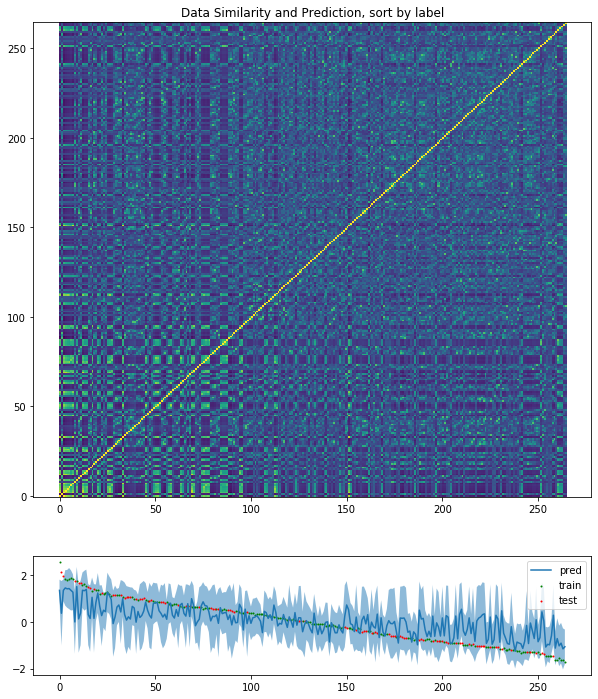

init kernel
groups:  ['all']
Group:  all
Number of sequences:  265
number of clusters:  34


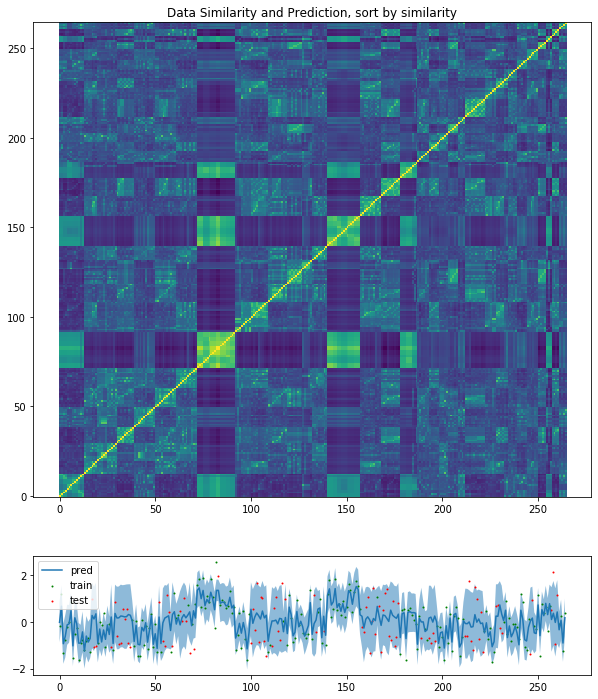

X train shape:  (1061, 20)
X test shape:  (89, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.1557397575554464
Test:  0.9180950270686048
<function r2_score at 0x7f02711216a8>
Train:  0.8208838422766607
Test:  0.01344550948171419


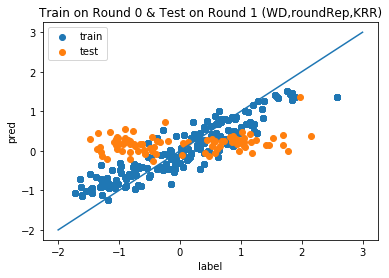

X train shape:  (1061, 80)
X test shape:  (89, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.17375302142971547
Test:  0.8311817108881598
<function r2_score at 0x7f02711216a8>
Train:  0.8001668033916667
Test:  0.10683967875134714
coverage rate: 
Train:  0.9321394910461829
Test:  0.8314606741573034


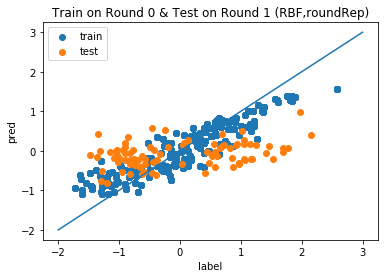

In [5]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

# run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
#                 test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (WD,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
                test_idx= round_df['Plate'] == 'Third_Plate',  title = 'Train on Round 0 & Test on Round 1 (WD,roundRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
                test_idx= round_df['Plate'] == 'Third_Plate', predictor=KRR_Predictor, title = 'Train on Round 0 & Test on Round 1 (WD,roundRep,KRR)')

kernel = 'RBF'
embedding = 'onehot'

# run_regression(plate_df, kernel, embedding, train_idx= plate_df['Plate'] != 'Third_Plate', 
#                 test_idx= plate_df['Plate'] == 'Third_Plate', title = ' Train on Round 0 & Test on Round 1 (RBF,plateRep)')
run_regression(round_df, kernel, embedding, train_idx= round_df['Plate'] != 'Third_Plate', 
                test_idx= round_df['Plate'] == 'Third_Plate',  title = 'Train on Round 0 & Test on Round 1 (RBF,roundRep)')

# train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, l = 6, s = 1, alpha = 2, eva_on='seqs')

# train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
#                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
#                    l = 6, s = 1, alpha = 2, eva_on='seqs')

## Train and Test on All Rounds Data

X train shape:  (1079, 20)
X test shape:  (53, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.23403089792288267
Test:  0.5954642850887153
<function r2_score at 0x7f02711216a8>
Train:  0.7369618746348396
Test:  0.26236083371266394
coverage rate: 
Train:  0.897126969416126
Test:  0.8113207547169812


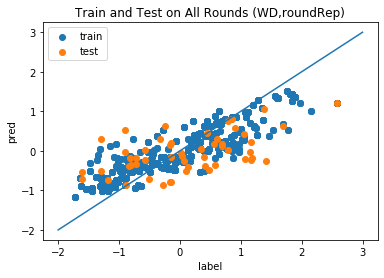

init kernel
groups:  ['all']
Group:  all
Number of sequences:  265
number of clusters:  54


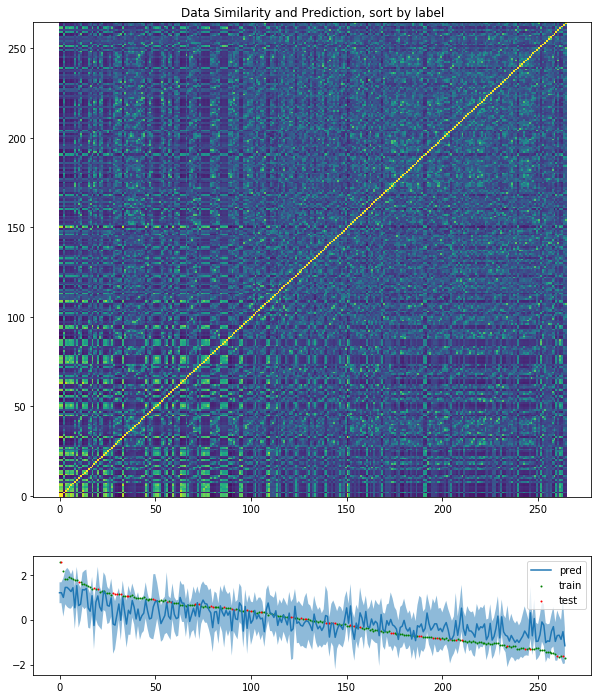

init kernel
groups:  ['all']
Group:  all
Number of sequences:  265
number of clusters:  34


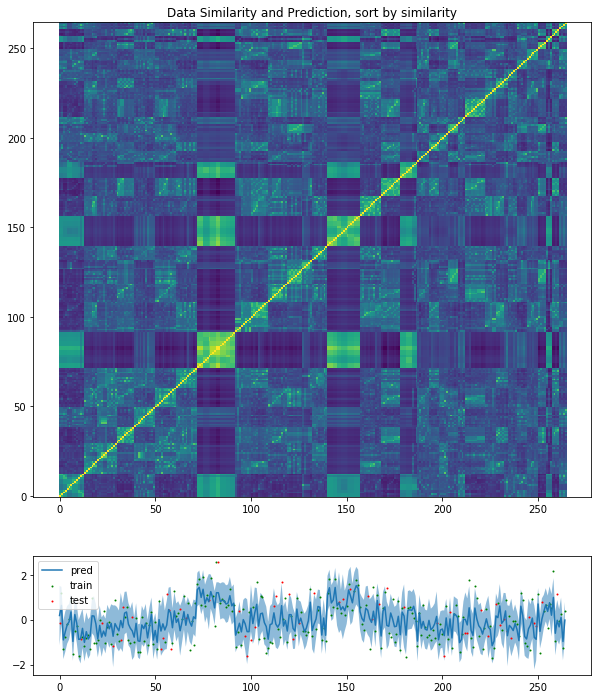

X train shape:  (1079, 20)
X test shape:  (53, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.23403029892187202
Test:  0.5954645354524121
<function r2_score at 0x7f02711216a8>
Train:  0.7369625478797159
Test:  0.2623605235713621


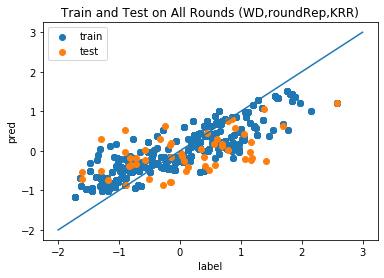

X train shape:  (1079, 80)
X test shape:  (53, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f0271121488>
Train:  0.25215774631886867
Test:  0.5773918549946344
<function r2_score at 0x7f02711216a8>
Train:  0.716588273272041
Test:  0.2847482927109779
coverage rate: 
Train:  0.8748841519925857
Test:  0.8301886792452831


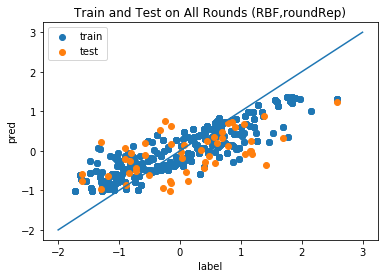

In [6]:
# setting
kernel = 'WD_Kernel_Shift' # 'RBF'
embedding = 'label' # 'onehot'

# run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (WD,roundRep)')
run_regression(round_df, kernel, embedding, predictor=KRR_Predictor, title = 'Train and Test on All Rounds (WD,roundRep,KRR)')

kernel = 'RBF'
embedding = 'onehot'

# run_regression(plate_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,plateRep)')
run_regression(round_df, kernel, embedding, title = 'Train and Test on All Rounds (RBF,roundRep)')

In [7]:
# kernel = 'RBF'
# embedding = 'onehot'
# eva_metric = [mean_squared_error, r2_score]

# # gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    alpha = 2, eva_on='seqs')

# # train and test on round 0
# gpr_train_samples = GPR_Predictor(df[df['Plate'] != 'Third_Plate'], kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, alpha = 2, eva_on='seqs')

# # train on round 0 (plate 1 and 2) and test on round 1 (plate 3)
# # gpr_train_samples = GPR_Predictor(df, train_idx= df['Plate'] != 'Third_Plate', test_idx= df['Plate'] == 'Third_Plate', 
# #                    kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
# #                    l = 6, s = 1, alpha = 2, eva_on='seqs')
# gpr_train_samples.regression()
# gpr_train_samples.scatter_plot()

## Conclusion

For train and test on round 0 or all rounds, WD is better than baseline and the prediction looks reasonable (test error is still big but at least show correct pattern). However, the generalisation between round 0 and round 1 is bad. For train on round 0 and test on round 1, WD is even worse than baseline. Both WD and baseline predictions look in the wrong range and pattern.
Several possible reasons:
- round 1 are areas we do not have enough information from round 0 (need to check by tsne?)
- normalisation over different rounds still problematic.
- in round 0 we have lots of sequences where the noncore part is not the same as our design space. The predictor trained on round 0 data could be biased.
- note the prediction is different from we have in the design file. Except for different normalisation methods for labels, the normalisation over kernels is different. For the design one, the kernel is normalised over all known sequences and design space; for this notebook, the kernel is normalised over input train and test data.


## Discussion

- the normalisation in terms of plate or round makes difference for our first experiment (train and test on Round 0)
- for all experiments, after the new normalisation, the high labels are fail to predict. Possible reasons:
    - non-core disruption?
    - feature space not complated enough.